<a href="https://colab.research.google.com/github/PRIMA-LAB-IPU/Lecture/blob/main/license-plate/tesseract_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tesseract本体とPythonラッパーをインストールします（Install Tesseract and its python wrapper）

In [1]:
!sudo apt-get purge tesseract-ocr libtesseract-dev tesseract-ocr-jpn
!sudo apt-get install tesseract-ocr libtesseract-dev tesseract-ocr-jpn
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'libtesseract-dev' is not installed, so not removed
Package 'tesseract-ocr' is not installed, so not removed
Package 'tesseract-ocr-jpn' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr
  tesseract-ocr-eng tesseract-ocr-jpn tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,949 kB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.3 [581 

# URLから画像を入手 (Get an image from a url)
Note: In order to read an image from the github, you need to modify the url.

[Original URL] https://github.com/PRIMA-LAB-IPU/Lecture/blob/019e2faa85a6ddd3858eafca94b6d9cf136de3b4/license-plate/car.jpg (It's not working)

[Modified URL] https://raw.githubusercontent.com/PRIMA-LAB-IPU/Lecture/019e2faa85a6ddd3858eafca94b6d9cf136de3b4/license-plate/car.jpg

In [39]:
import urllib.request
# url = 'https://raw.githubusercontent.com/PRIMA-LAB-IPU/Lecture/019e2faa85a6ddd3858eafca94b6d9cf136de3b4/license-plate/car.jpg'
# url = 'https://raw.githubusercontent.com/PRIMA-LAB-IPU/Lecture/5599067a1c107aee6464854e409e1186d3bc9165/license-plate/other-car.jpg'

# False recognition on below picture
url = 'https://raw.githubusercontent.com/PRIMA-LAB-IPU/Lecture/558dae4bf1d1525c66b3b73c9d4d06781848faf7/license-plate/car-sport.jpeg'

file_name = 'car.jpg'
urllib.request.urlretrieve(url, file_name)

('car.jpg', <http.client.HTTPMessage at 0x7a34d6038b50>)

# ライブラリの呼び出し（Import libraries）

In [40]:
# パッケージをインポート
import numpy as np
import cv2
import  imutils
import sys
import pytesseract
from pytesseract import Output
import time
import matplotlib.pyplot as plt

# 画像表示関数（Display function）

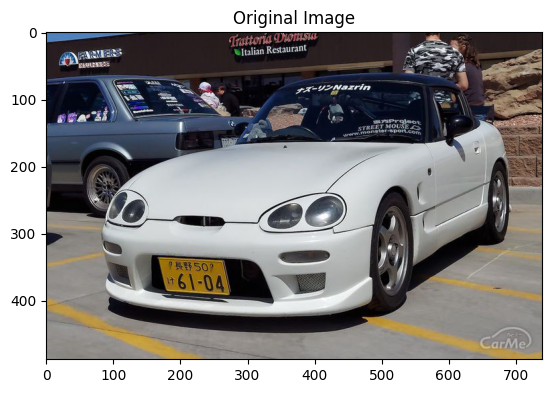

In [41]:
# 画像表示用
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

 # 画像読み込みして表示
image = cv2.imread(file_name)
plt_imshow("Original Image", image)

# ナンバープレート領域の同定（Find the license plate region using contour detection）

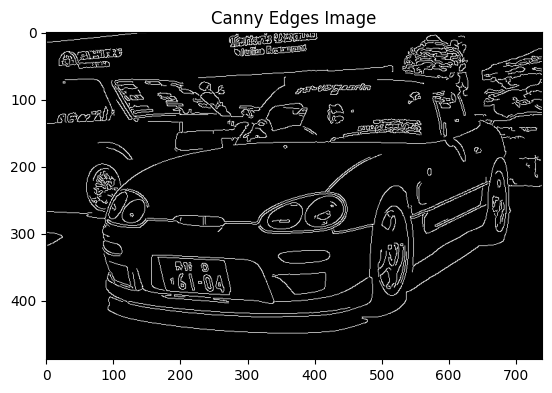

In [42]:
# Cannyエッジ検出
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)
plt_imshow("Canny Edges Image", edged)

# 輪郭検出
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

In [43]:
# 取得した輪郭から形状の近似を行い長方形を探す
number_contours = None
for c in contours:
  perimeter = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
  if len(approx) == 4:
      number_contours = approx
      break

print(number_contours)

[[[166 336]]

 [[180 386]]

 [[273 392]]

 [[265 341]]]


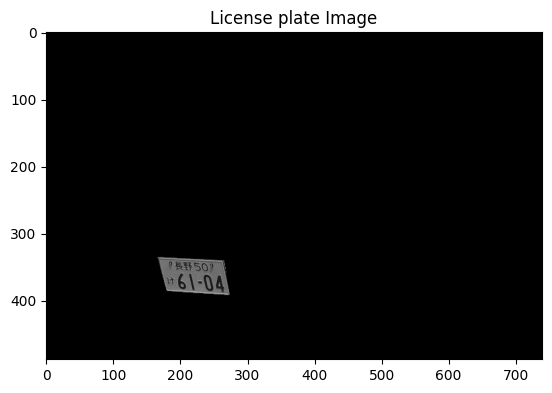

9時時SQ 1
6UOA



In [57]:
# ナンバープレート以外はマスクする
if number_contours is not None:
  mask = np.zeros(gray.shape,dtype="uint8")
  image_plate = cv2.drawContours(mask,[number_contours],0,255,-1)
  image_plate = cv2.bitwise_and(gray,gray,mask=mask)
  plt_imshow("License plate Image",image_plate)

# ナンバープレート画像からテキスト検出
# config = ('-l jpn --oem 3 --psm 6 -c tessedit_char_whitelist="0123456789-あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわをん" ')
config = ('-l jpn --oem 3 --psm 6  ')
text = pytesseract.image_to_string(image_plate, config=config)

if text:
  print(text)
else:
  print("Could not read license plate.")

# Enhance the image shape to get better recognition

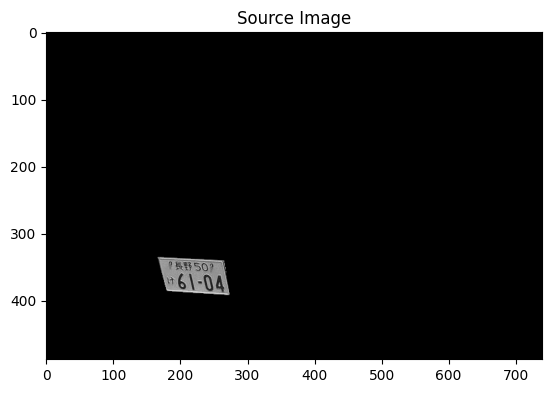

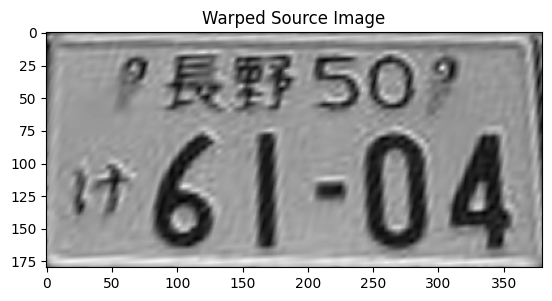

| 長野SO
604



In [58]:
import cv2
import numpy as np

# Read source image.
# pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]])
pts_src = number_contours

# Four corners of the book in destination image.
pts_dst = np.array([[0, 0],[0, 180],[380, 180],[380, 0]])

# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

# Create a 380x180 image of zeros (grayscale)
image = np.zeros((180, 380), dtype=np.uint8)

# Warp source image to destination based on homography
warped_image = cv2.warpPerspective(image_plate, h, (image.shape[1],image.shape[0]))

# Display images
plt.imshow(image_plate, cmap='gray')  # Displaying image_plate with a grayscale colormap
plt.title("Source Image")
plt.show()

plt.imshow(warped_image, cmap='gray')  # Displaying warped image with a grayscale colormap
plt.title("Warped Source Image")
plt.show()

# ナンバープレート画像からテキスト検出
# config = ('-l jpn --oem 3 --psm 6 -c tessedit_char_whitelist="0123456789-あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわをん" ')
config = ('-l jpn --oem 3 --psm 6  ')
text = pytesseract.image_to_string(warped_image, config=config)

if text:
  print(text)
else:
  print("Could not read license plate.")